In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
input_dir = "../input/chest-xray-pneumonia/chest_xray/"
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

In [15]:
def load_traindata(path):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                 horizontal_flip=True,
                                 zoom_range=0.2,
                                 shear_range=0.2,
                                 rotation_range=5
                                 )
    traindata = datagen.flow_from_directory(
              path,
              target_size=(224,224),
              batch_size=16,
              class_mode='categorical')  
    return traindata

def load_test_val_data(path):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    testvaldata = datagen.flow_from_directory(
              path,
              target_size=(224,224),
              batch_size=16,
              class_mode='categorical')
    return testvaldata

Train = load_traindata(train_dir)
Test = load_test_val_data(test_dir)
Validation = load_test_val_data(val_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Text(0.5, 1.0, 'infected chest')

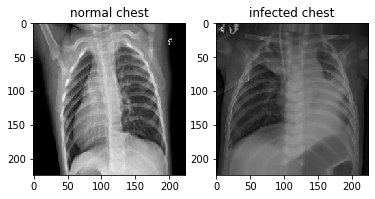

In [16]:
#Display Training images
fig, ax = plt.subplots(1,2)
batch1 = Train[0]

count = 0
for target in batch1[1]:
    if target[0] == 1:
        normal = count
    else:
        infected = count
    count = count + 1    

ax[0].imshow(batch1[0][normal], interpolation='nearest')
ax[0].set_title('normal chest')
    
ax[1].imshow(batch1[0][infected], interpolation='nearest')
ax[1].set_title('infected chest')

In [17]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope(): 
    pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3))
    pretrained_model.trainable = False
   
    x = tf.keras.layers.Flatten()(pretrained_model.output)#flattening out the last layer
    x = tf.keras.layers.Dense(4096, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    predictions = tf.keras.layers.Dense(2,activation='softmax')(x) #Dense layer to predict wether their is pneumonia or not
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions)

    model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [18]:
with strategy.scope():
    history = model.fit_generator(Train,
        steps_per_epoch=15,
        epochs=40,
        validation_data=Validation,
        validation_steps=10)

Epoch 1/40
15/15 [==============================] - 23s 686ms/step - loss: 45.7430 - accuracy: 0.7218 - val_loss: 8.1302 - val_accuracy: 0.9375
Epoch 2/40
15/15 [==============================] - 6s 396ms/step - loss: 8.8765 - accuracy: 0.8850
Epoch 3/40
15/15 [==============================] - 6s 362ms/step - loss: 13.2476 - accuracy: 0.9043
Epoch 4/40
15/15 [==============================] - 5s 348ms/step - loss: 5.3383 - accuracy: 0.9351
Epoch 5/40
15/15 [==============================] - 6s 400ms/step - loss: 4.1397 - accuracy: 0.9159
Epoch 6/40
15/15 [==============================] - 5s 335ms/step - loss: 2.5694 - accuracy: 0.9266
Epoch 7/40
15/15 [==============================] - 5s 357ms/step - loss: 0.6016 - accuracy: 0.9664
Epoch 8/40
15/15 [==============================] - 5s 352ms/step - loss: 0.8206 - accuracy: 0.9176
Epoch 9/40
15/15 [==============================] - 5s 320ms/step - loss: 3.4853 - accuracy: 0.9080
Epoch 10/40
15/15 [==============================] - 5s

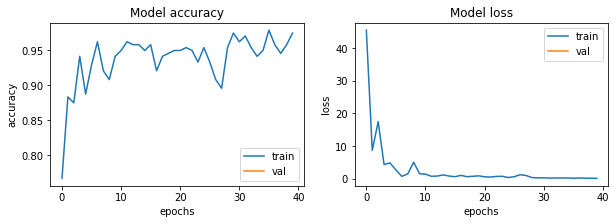

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
#Test Accuracy:
loss, acc = model.evaluate_generator(Test)
print ("The test dataset accuracy is "+str(round(acc*100,2))+ "% with loss " + str(round(loss,4)))

The test dataset accuracy is 92.63% with loss 0.2245
